# Simulating the power of the t-test in R

This note notebook simulates T-statistcs

$$
T = \frac{\hat{\beta}_1 - \beta_{1,0}}{SE(\hat{\beta}_1)}
$$

when $\beta_1$ is estimated from the model

$$
\texttt{income} = \beta_0 + \beta_1 \texttt{cost} + U.
$$

The simulation code specifies the joint distribution of $(\texttt{cost}, U)$
 
For each simulation run, the code draws data $(\texttt{cost}, U)$ and computes the outcome $\texttt{income}$ according to the linear model above. Then, it estimates $\hat{\beta}_1$ and its standard error $SE(\hat{\beta}_1)$ based on the simulation data. 

In this notebook, you can set the true value of $\beta_1$ and the hypothesized value $\beta_{1,0}$ to see how the distribution of $T$ changes.

In [60]:
library(dplyr)
library(ggplot2)


simulate_tstat <- function(sample_size, true_beta1 = 3) {
  
  draw_sample <- function(nobs, true_beta1 = 3) {
    tibble(
      cost = sample(c(1100, 1350, 1500, 1600, 1770, 2200), size = nobs, replace = TRUE),
      U = 0.8 * (cost / 2 + (cost / 200)^2) * (rchisq(nobs, df = 6) - 6),
      income = 40000 + true_beta1 * cost + U
    )
  }

  compute_stats <- function(tb) {
    lmfit <- lm(income ~ cost, data = tb)
    se1 <- sqrt(diag(sandwich::vcovHC(lmfit, "HC1"))["cost"])
    betah1 <- coef(lmfit)["cost"]
    tibble(betahat1 = betah1, se1 = se1, num_obs = nobs(lmfit))
  }

  compute_stats(draw_sample(sample_size, true_beta1))
}

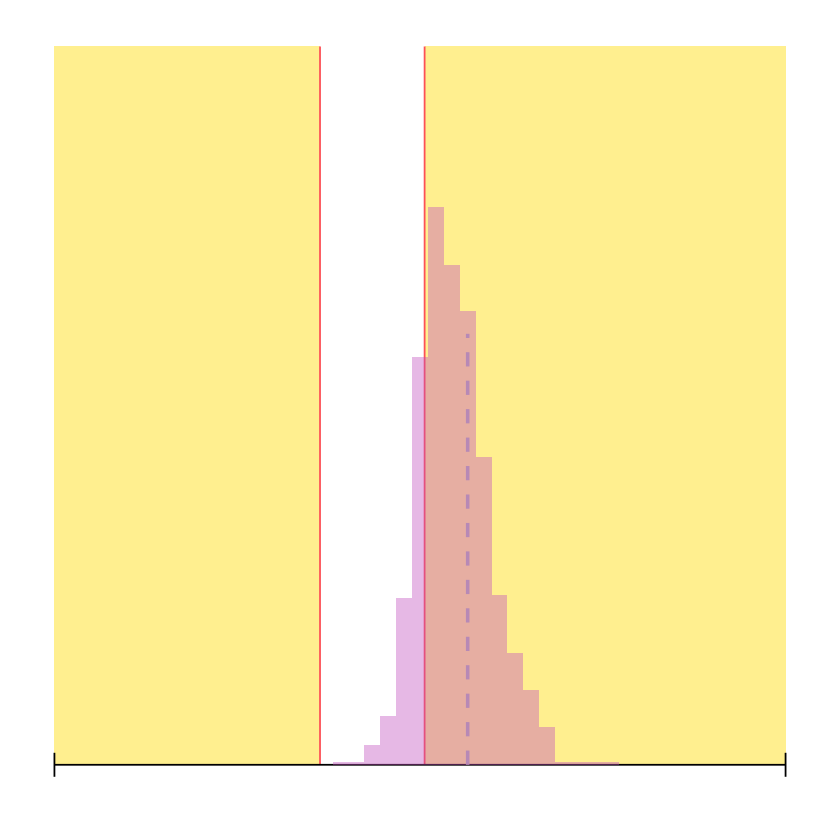

In [61]:
coord_min <- -10
coord_max <- 13
coord_mid <- 3

simulate_and_plot <- function(num_simulations = 100, tested_beta1 = 0, show_rejection_region = TRUE, point_per_observation = FALSE, ...) {
  sim_results <-
    bind_rows(lapply(seq_len(num_simulations), \(s) simulate_tstat(...))) |>
    mutate(
      s = row_number(),
      tstat = (betahat1 - tested_beta1) / se1
    )

  suppressWarnings({
    p <- sim_results |>
      # filter(betahat1 >= coord_min, betahat1 <= coord_max) |>
      ggplot(aes(x = tstat, y = 0))

    if (show_rejection_region) {
      p <- p + geom_rect(aes(xmin = coord_min, ymin = 0, xmax = qnorm(0.1 / 2), ymax = 0.5),
        fill = "lightgoldenrod1", alpha = 0.03
      ) +
        geom_rect(aes(xmin = qnorm(1 - 0.1 / 2), ymin = 0, xmax = coord_max, ymax = 0.5),
          fill = "lightgoldenrod1", alpha = 0.03
        ) +
        annotate(
          "segment",
          x = qnorm(0.1 / 2), xend = qnorm(0.1 / 2),
          y = 0, yend = 0.5,
          color = "indianred1"
        ) +
        annotate(
          "segment",
          x = qnorm(1 - 0.1 / 2), xend = qnorm(1 - 0.1 / 2),
          y = 0, yend = 0.5,
          color = "indianred1"
        )
    }
    p <- p +
      # geom_segment(aes(x = 0, xend = Delta1,
      #                 y = -0.015, yend = -0.015), color = "seagreen", lwd = 1.2,
      #             arrow = arrow(angle = 90, end = "both", length = unit(0.06, "inches")),
      #             data = sim_results_labels) +
      annotate(
        "segment",
        x = coord_min, xend = coord_max,
        y = 0, yend = 0,
        size = 0.5,
        arrow = arrow(angle = 90, end = "both", length = unit(0.1, "inches"))
      ) +
      annotate(
        "segment",
        x = coord_mid, xend = coord_mid,
        y = 0, yend = 0.3,
        size = 1, color = "grey", linetype = "dashed"
      ) +
      geom_histogram(
        aes(y = after_stat(density)),
        fill = "orchid3", alpha = 0.4, binwidth = 0.5
      ) 

    if (point_per_observation) {
      p <- p + geom_point(size = 4, color = "lightskyblue") 
    }

      #   scale_x_continuous(limits = c(coord_min, coord_max)) +
    
    p +
      scale_y_continuous(limits = c(-0.02, 0.5)) +
      theme(
        panel.background = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank()
      )
  })
}

simulate_and_plot(
  num_simulations = 1000,
  true_beta1 = 3,
  tested_beta1 = 0,
  sample_size = 40
)